In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
import datetime
import category_encoders as ce
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared

In [3]:
path = Path("..")
path_ds = path/'datasets'
path_res = path/'res_data'
path_plot = path/'plots'

In [26]:
res = []
test = {}

products = ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']

for method in ['one-hot encoding', 'target encoding']:   
        
        if method == 'one-hot encoding':
            df = load_yaz(encode_date_features=True, include_prod=None, include_date=False).frame
        else:
            df = load_yaz(encode_date_features=False, include_prod=None, include_date=False).frame
        
        # make train/val/test
        n_train = 600
        train_df, test_df = df.iloc[:n_train, :], df.iloc[n_train:, :]
        n_test = len(test_df)
        
        train_df = pd.melt(train_df,
             id_vars = train_df.columns.difference(products),
             value_vars= products)

        test_df = pd.melt(test_df,
             id_vars = test_df.columns.difference(products),
             value_vars= products) 
        
        train_x_df, train_y_df = train_df.iloc[:, :-1], train_df.iloc[:, -1]
        test_x_df, test_y_df = test_df.iloc[:, :-1], test_df.iloc[:, -1]
        
        train_y = train_y_df.values
        test_y = test_y_df.values

        # target encoding
        if method == 'target encoding':
            for cat in ['WEEKDAY', 'MONTH', 'YEAR', 'ISHOLIDAY', 'WEEKEND', 'variable']:
                encoder = ce.TargetEncoder()
                train_x_df[cat] = encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)
                test_x_df[cat] = encoder.transform(test_x_df[cat].astype('category'))
        elif method == 'one-hot encoding':
            for cat in ['variable']:
                encoder = ce.OneHotEncoder()
                train_x_df = pd.concat([train_x_df, encoder.fit_transform(train_x_df[cat].astype('category'), train_y_df)], axis=1).drop(columns = cat)
                test_x_df = pd.concat([test_x_df, encoder.transform(test_x_df[cat].astype('category'))], axis=1).drop(columns = cat)
    
        scaler = MinMaxScaler()
        scaler.fit(train_x_df)

        train_x = scaler.transform(train_x_df)
        test_x = scaler.transform(test_x_df)

        # Kernel with parameters given in GPML book
        k1 = 1**2 * RBF(length_scale=0.261)  # long term smooth rising trend
        k2 = 2.4**2 * RBF(length_scale=90.0) \
            * ExpSineSquared(length_scale=1.3, periodicity=1.0)  # seasonal component
        k3 = 0.66**2 \
            * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
        k4 = 0.18**2 * RBF(length_scale=0.134) \
            + WhiteKernel(noise_level=1.09**2)  # noise terms

        if method == 'timeseries':
            kernel_gpml = k1 + k2 + k3 + k4

        elif method == 'one-hot encoding':
            kernel_gpml = k1 + k4

        elif method == 'target encoding':
            kernel_gpml = k1 + k4

        gp = GaussianProcessRegressor(kernel=kernel_gpml, normalize_y=True)#, alpha=1)
        gp.fit(train_x, train_y)

        print("\nLearned kernel: %s" % gp.kernel_)
        print("Log-marginal-likelihood: %.3f"
              % gp.log_marginal_likelihood(gp.kernel_.theta))

        nv_means, y_std = gp.predict(test_x,  return_std=True)
        nv_sigma = y_std
        
        for i, target in enumerate(products):
            for c in range(5,100, 5):
                cu = c/100
                co = 1-cu

                nv_solution = nv_means[i*n_test:(i+1)*n_test]+norm.ppf(cu/(cu+co))*nv_sigma[i*n_test:(i+1)*n_test]
                cost =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, test_y[i*n_test:(i+1)*n_test])])
                
                test[target, c, 'diff',  'test'] = nv_solution - test_y[i*n_test:(i+1)*n_test]
                test[target, c, 'solution', 'test'] = nv_solution
                test[target, c, 'value', 'test'] = train_y[i*n_test:(i+1)*n_test]
                test[target, c, 'mean',  'test'] = nv_means[i*n_test:(i+1)*n_test]
                test[target, c, 'std',  'test'] = nv_sigma[i*n_test:(i+1)*n_test]

                ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target, "split": 'test'})
                res.append(ser_tmp)
                
        nv_means, y_std = gp.predict(train_x,  return_std=True)
        nv_sigma = y_std
        
        for i, target in enumerate(products):
            for c in range(5,100, 5):
                cu = c/100
                co = 1-cu

                nv_solution = nv_means[i*n_train:(i+1)*n_train]+norm.ppf(cu/(cu+co))*nv_sigma[i*n_train:(i+1)*n_train]
                
                cost =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, train_y[i*n_train:(i+1)*n_train])])
                
                test[target, c, 'diff', 'train'] = nv_solution - train_y[i*n_train:(i+1)*n_train]
                test[target, c, 'solution', 'train'] = nv_solution
                test[target, c, 'value', 'train'] = train_y[i*n_train:(i+1)*n_train]
                test[target, c, 'mean',  'train'] = nv_means[i*n_train:(i+1)*n_train]
                test[target, c, 'std',  'train'] = nv_sigma[i*n_train:(i+1)*n_train]


                ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target, "split": 'train'})
                res.append(ser_tmp)
            #df_res = pd.DataFrame(res)

for target in products:
    method = 'saa'
    df = load_yaz(encode_date_features=False, include_prod=[target], include_date=False).frame
    # make train/val/test
    n_train = 600
    train_df, test_df = df.iloc[:n_train, :], df.iloc[n_train:, :]

    train_x_df, train_y_df = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    test_x_df, test_y_df = test_df.iloc[:, :-1], test_df.iloc[:, -1]

    train_y = train_y_df.values
    test_y = test_y_df.values

    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu

        nv_quantile = np.quantile(train_y, q=cu/(cu+co))
        cost= np.mean([nv_cost(nv_quantile, y, cu, co) for y in test_y])
        nv_means, nv_sigma = 0,0

        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost, "type":method, "target": target, "split": 'train'})
        res.append(ser_tmp)
        
df_res = pd.DataFrame(res)

/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):



Learned kernel: 1.14**2 * RBF(length_scale=2.39) + 0.00436**2 * RBF(length_scale=0.013) + WhiteKernel(noise_level=0.167)
Log-marginal-likelihood: -2710.930


/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/home/magr/anaconda3/envs/gp/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/hom


Learned kernel: 1.34**2 * RBF(length_scale=1.5) + 0.234**2 * RBF(length_scale=0.163) + WhiteKernel(noise_level=0.147)
Log-marginal-likelihood: -2555.874


In [39]:
for c in range(5,100, 5):
    cu = c/100
    co = 1-cu
    print(norm.ppf(cu/(cu+co)))

-1.6448536269514729
-1.2815515655446004
-1.0364333894937898
-0.8416212335729142
-0.6744897501960817
-0.5244005127080409
-0.38532046640756773
-0.2533471031357997
-0.12566134685507402
0.0
0.12566134685507416
0.2533471031357997
0.38532046640756773
0.5244005127080407
0.6744897501960817
0.8416212335729143
1.0364333894937898
1.2815515655446004
1.6448536269514722


nnn= 'SOF_results_Symmetric.csv'
df_tmp = pd.read_csv(nnn)
#df_tmp = df_tmp.drop(columns=["Unnamed: 0"])
df_tmp['target']="STEAK"
df_tmp.to_csv(nnn, index=False)

In [27]:
test['CALAMARI', 5, 'std', 'test'].min()

5.604201226498523

In [41]:
test['CALAMARI', 5, 'std', 'test']

array([6.46994298, 6.45144166, 6.51269895, 7.27003664, 6.72134363,
       6.73299928, 6.66703034, 6.60689295, 6.55477997, 6.58493091,
       6.45044225, 6.51799795, 6.67562579, 6.72041902, 6.55054557,
       6.51565113, 6.44355974, 6.63636846, 6.53306572, 6.68487302,
       6.6502413 , 6.55113545, 6.48563515, 6.44418413, 6.48946777,
       6.51340188, 6.63222525, 6.65600003, 6.51353995, 6.68215957,
       6.41077092, 6.45400109, 6.47068602, 6.86624726, 6.8442894 ,
       6.29258916, 6.37113315, 6.40395916, 6.0823472 , 6.23130418,
       6.76140261, 6.43356359, 6.27372752, 6.27730119, 6.26281242,
       6.3859833 , 6.43258685, 6.42123815, 6.44977216, 6.31707905,
       6.31817091, 6.28785635, 6.23210492, 6.31664238, 6.77520238,
       6.10970691, 6.27959645, 6.13605106, 6.01868962, 6.08810197,
       5.98959796, 6.18279866, 6.44565355, 6.38076048, 6.23054606,
       6.09774769, 6.2989157 , 6.51860878, 6.68864595, 6.4620886 ,
       6.28914034, 5.99966814, 6.30043745, 6.3398138 , 8.73625

In [35]:
test['CALAMARI', 5, 'mean', 'test']

array([ 3.93518248,  4.45682066,  5.07915273,  2.49057867,  5.39412387,
        2.60172977,  2.4695861 ,  3.71580981,  4.75254197,  5.54967961,
        4.79943228,  5.53439339,  2.57338437,  2.64966438,  4.0839092 ,
        4.97680589,  5.22794012,  4.38227074,  6.62950373,  8.42667743,
        4.21221207,  3.59873626,  4.30030469,  5.07222147,  5.35871174,
        5.91902835,  3.78149065,  3.03472864,  3.68460422,  4.50647019,
        3.39430933,  3.12576766,  4.32843861,  0.66866144,  1.19457814,
        2.88676766,  2.97477432,  5.52922773,  5.14006918,  5.26742867,
        1.48867683,  2.87378963,  4.16874938,  4.34084645,  3.65176042,
        3.19681898,  4.35971513,  4.33182173,  4.59777055,  3.5026014 ,
        3.00705689,  4.33000249,  4.62696992,  4.6313933 ,  4.61453766,
        2.53609316,  4.69951773,  4.4763765 ,  4.00422752,  4.68602113,
        5.58825008,  8.11162312,  1.38996849,  2.16574927,  4.23608327,
        3.12806276,  2.87672446,  3.76139482,  2.52684636,  2.93

In [30]:
test['CALAMARI', 5, 'std', 'test'].min()

5.604201226498523

In [31]:
test['CALAMARI', 5, 'diff', 'test']

array([-12.7069267 , -10.15485654, -12.63328376, -10.46756746,
        -8.66150257, -11.47306851,  -9.49670294,  -9.15156203,
        -9.02911163, -11.28156788,  -5.81060105, -12.18675918,
       -14.40704292,  -9.40444122,  -6.69077944,  -7.74048651,
        -7.37077249,  -9.53358399,  -9.11643312,  -7.56896021,
        -8.72646145, -10.17692264, -10.3676158 , -11.52751816,
        -8.31551285,  -6.79456436, -17.12754911, -11.91341714,
        -9.02921559,  -7.48470421, -15.15047046, -13.49011944,
       -14.31489276, -12.62531027, -13.06327611, -12.46362044,
       -12.50480716, -10.00434771, -11.86450167,  -9.9821546 ,
       -13.63284077,  -7.70848078, -11.15061409, -11.98439519,
       -11.6496493 ,  -8.30718881,  -8.22094868,  -7.23017514,
        -6.01116058,  -9.88806898, -12.38540946, -10.01260084,
       -10.62393046, -12.75855883, -11.52967855, -12.51348042,
        -6.62949926,  -7.61652934,  -9.89563593, -10.32801548,
        -5.26376185,  -9.05817568, -11.21218814, -12.32

In [34]:
test['CALAMARI', 5, 'value', 'test']

array([ 6,  8,  6,  4,  7,  7,  3,  5,  5,  1,  2,  2,  8,  6,  7, 10,  6,
        5,  3,  5,  6,  5,  4,  8,  5,  5,  4,  4,  0, 25,  3,  0,  2,  7,
        5,  7,  8,  6,  3,  2,  4,  3,  7,  4,  1,  4,  4,  5,  7,  4,  6,
        4,  4,  4,  1,  4,  5, 13,  1,  4,  3,  2,  7,  9, 11,  4,  3,  5,
        4,  3,  5,  6,  4,  2,  4,  1,  7,  7,  3,  4,  6,  1,  4, 11,  7,
        6,  8,  3,  0,  7,  8,  4,  2,  2,  8,  4,  5, 12, 11,  2,  2, 11,
        9,  4,  9, 10,  2,  2,  6,  8,  6,  6,  7,  4,  1,  3, 24,  8,  4,
        6,  0,  0,  2,  1,  4,  5, 10,  5,  2,  5,  4,  4, 14,  6,  3,  1,
        1,  5,  3,  2, 14,  7,  4,  6,  5,  4,  4,  8,  4,  0,  3,  3,  7,
        5,  9,  6,  1,  5,  4,  8])

In [33]:
test['CALAMARI', 5, 'solution', 'test']

array([ -6.7069267 ,  -6.15485654,  -5.63328376,  -9.46756746,
        -5.66150257,  -8.47306851,  -8.49670294,  -7.15156203,
        -6.02911163,  -5.28156788,  -5.81060105,  -5.18675918,
        -8.40704292,  -8.40444122,  -6.69077944,  -5.74048651,
        -5.37077249,  -6.53358399,  -4.11643312,  -2.56896021,
        -6.72646145,  -7.17692264,  -6.3676158 ,  -5.52751816,
        -5.31551285,  -4.79456436,  -7.12754911,  -7.91341714,
        -7.02921559,  -6.48470421,  -7.15047046,  -7.49011944,
        -6.31489276, -10.62531027, -10.06327611,  -7.46362044,
        -7.50480716,  -5.00434771,  -4.86450167,  -4.9821546 ,
        -9.63284077,  -7.70848078,  -6.15061409,  -5.98439519,
        -6.6496493 ,  -7.30718881,  -6.22094868,  -6.23017514,
        -6.01116058,  -6.88806898,  -7.38540946,  -6.01260084,
        -5.62393046,  -5.75855883,  -6.52967855,  -7.51348042,
        -5.62949926,  -5.61652934,  -5.89563593,  -5.32801548,
        -4.26376185,  -2.05817568,  -9.21218814,  -8.32

In [ ]:
y

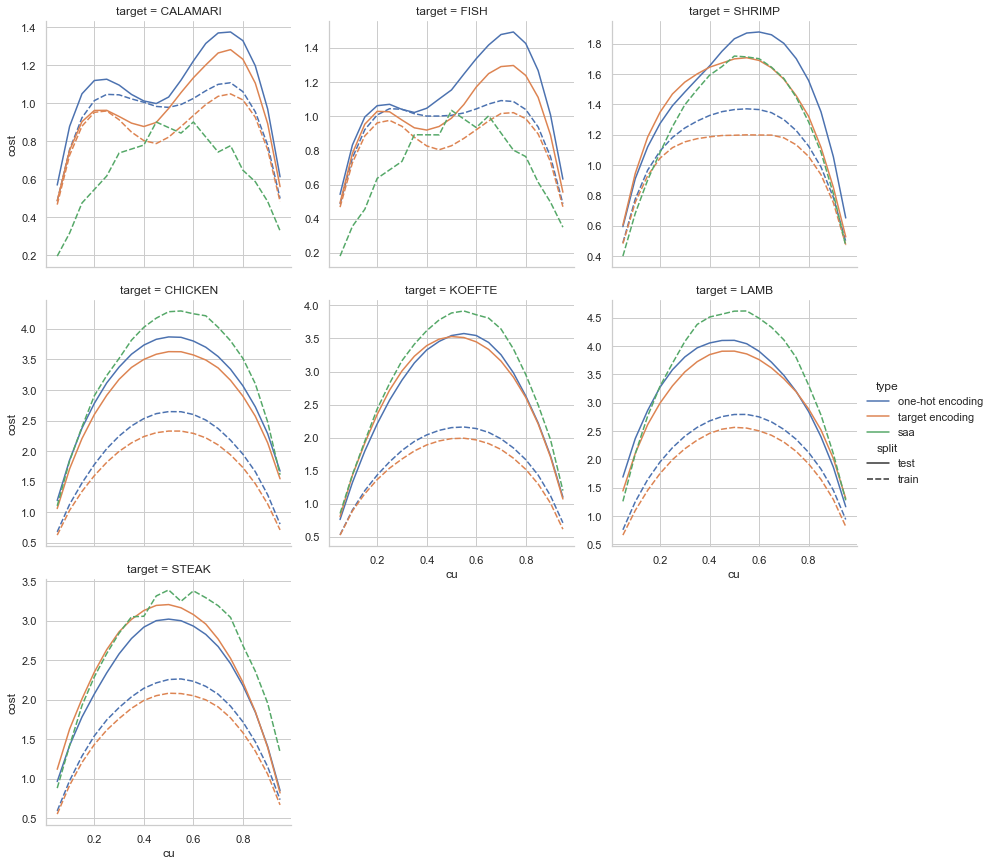

In [10]:
df_plot = df_res
#df_plot = pd.read_csv('res_data/gp_all-paste.csv')
df_plot = df_plot[~(df_plot.type.isin(["rf_rf", "rf_grf", "rf_oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["rf_approx_risk", "rf_approx_sol", "oracle"]))]
#df_plot = df_plot[~(df_plot.type.isin(["saa", "rf"]))]
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",col_wrap=3,facet_kws={'sharey':False},style='split',
    col="target", hue="type",kind="line", aspect=1, height=4); 